# 0. Hyperparameters
and imports

In [1]:
from evaluate_yolo_tracker import evaluate_sequence, VAL_SEQUENCES
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pandas as pd
import numpy as np
import cv2
import os

Error importing BURST due to missing underlying dependency: No module named 'pycocotools'


In [2]:
IOU_ASSOCIATION_TRESHOLD = 0.5
CONF_TRESHOLD = 0.2
project = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/SharkTrack-Dev/models/p2v4_new_1000e_no_patience/'
custom_botsort_path = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/SharkTrack-Dev/trackers/custom_botsort.yaml'

# 1. Run Tracking

In [3]:
model_path = os.path.join(project, 'weights/best.pt')

custom = False
tracker = custom_botsort_path if custom else 'botsort'


print(tracker)
motas, motps, idf1s, hotas, track_time, _, aligned_annotations_list = evaluate_sequence(model_path, CONF_TRESHOLD, IOU_ASSOCIATION_TRESHOLD, imgsz=640, tracker_type=tracker)
print(f'MOTA: {motas}, MOTP: {motps}, IDF1: {idf1s}, HOTA: {hotas}, {track_time=}s')

botsort
Evaluating val1_difficult1
Running track mode...
Processing frame 20

Processed 20 frames in track mode.
Sequence processing time: 4.65s
Evaluating val1_difficult2
Running track mode...
Processing frame 20

Processed 20 frames in track mode.
Sequence processing time: 2.92s
Evaluating val1_easy1
Running track mode...
Processing frame 20

Processed 20 frames in track mode.
Sequence processing time: 3.13s
Evaluating val1_easy2
Running track mode...
Processing frame 20

Processed 20 frames in track mode.
Sequence processing time: 2.97s
Evaluating val1_medium1
Running track mode...
Processing frame 20

Processed 20 frames in track mode.
Sequence processing time: 3.01s
Evaluating val1_medium2
Running track mode...
Processing frame 20

Processed 20 frames in track mode.
Sequence processing time: 2.53s

Eval Config:
USE_PARALLEL         : False                         
NUM_PARALLEL_CORES   : 8                             
BREAK_ON_ERROR       : True                          
RETURN_ON_

<Figure size 640x480 with 0 Axes>

# Investigate with GT
For frames with poor graph performance, show the GT and PRED bounding boxes

In [7]:
def draw_bbox(img, gt_bbox, pred_bbox, pred_conf, track_ids):
  color1 = (0, 255, 0)
  color2 = (0, 0, 255)

  for bbox in gt_bbox:
    bbox = np.array(bbox).astype(int)
    pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
    img = cv2.rectangle(img, pt1, pt2, color1, int(max(img.shape[:2]) / 200))

  for i, pair in enumerate(zip(pred_bbox, pred_conf)):
    bbox, conf = pair
    bbox = np.array(bbox).astype(int)
    pt1, pt2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])
    img = cv2.rectangle(img, pt1, pt2, color2, int(max(img.shape[:2]) / 200))
    text = f'Pred: {conf:.2f}'
    if len(track_ids) > 0:
      text += f' (ID: {track_ids[i]})'
    img = cv2.putText(img, text, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color2, 1, cv2.LINE_AA)

  # Add legend for color
  img = cv2.putText(img, 'Ground Truth', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color1, 2, cv2.LINE_AA)
  img = cv2.putText(img, 'Predictions', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, color2, 2, cv2.LINE_AA)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_rgb)


def plot_frame(frame_path, frame_num, aligned_annotations):
  """
  Plots the ground truth and predicted bounding boxes of a given frame.
  """
  gt_bbox = aligned_annotations['gt_bbox_xyxys'][frame_num]
  pred_bbox = aligned_annotations['pred_bbox_xyxys'][frame_num]
  pred_conf = aligned_annotations['pred_confidences'][frame_num]
  track_ids = aligned_annotations['pred_track_ids']
  if len(track_ids) > 0:
    track_ids = track_ids[frame_num]

  # Convert frame number to timestamp (in milliseconds)
  timestamp = (frame_num / 10) * 1000  # frame_num / fps * 1000

  # Read the frame
  frame = cv2.imread(frame_path)

  # Plot the ground truth and predicted bounding boxes
  draw_bbox(frame, gt_bbox, pred_bbox, pred_conf, track_ids)

In [8]:
dataset = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/phase2'
sequence = 'val1_difficult2'
frame_to_inspect = 5
frame_name = f'{sequence}_frame{frame_to_inspect*30}.jpg'
frame_path = os.path.join(dataset, sequence, frame_name)
plot_frame(frame_path, frame_to_inspect, aligned_annotations_list[0])

KeyError: 0

In [ ]:
# Bulk It
i = 2
sequence = VAL_SEQUENCES[i]
print(f'Inspecting sequence {sequence}')
seq_annotations = aligned_annotations_list[sequence]
for frame_to_inspect in range(len(seq_annotations['gt_bbox_xyxys'])):
  conf = seq_annotations['pred_confidences'][frame_to_inspect]
  print(f'Frame {frame_to_inspect}, conf: {conf}')
  frame_name = f'{sequence}_frame{frame_to_inspect*30}.jpg'
  frame_path = os.path.join(dataset, sequence, frame_name)
  plot_frame(frame_path, frame_to_inspect, seq_annotations)
  plt.show()
  plt.pause(1)

# Investigate Inference

In [8]:
def get_annotations(df, frame_num):
  """
  Given dataframe with following columns:
  row['4-7: Img-bbox(TL_x']
  row['TL_y']
  row['BR_x']
  row['BR_y)']

  extract list of bounding boxes for col '3: Unique Frame Identifier' = frame_num
  """
  bboxes = df[df['3: Unique Frame Identifier'] == frame_num][['4-7: Img-bbox(TL_x', 'TL_y', 'BR_x', 'BR_y)']].values.tolist()
  confs = df[df['3: Unique Frame Identifier'] == frame_num]['8: Detection or Length Confidence'].values.tolist()
  pred_track_ids = df[df['3: Unique Frame Identifier'] == frame_num]['# 1: Detection or Track-id'].values.tolist()
  return bboxes, confs, pred_track_ids

def plot_from_video(video, frame_num, fps, annotations):
  """
  Plots the ground truth and predicted bounding boxes of a given frame.
  """
  pred_bboxes, pred_confs, pred_track_ids = get_annotations(annotations, frame_num)

  # Convert frame number to timestamp (in milliseconds)
  timestamp = (frame_num / fps) * 1000  # frame_num / fps * 1000

  # Extract the frame from the video at the specific timestamp
  cap = cv2.VideoCapture(video)
  cap.set(cv2.CAP_PROP_POS_MSEC, timestamp)
  ret, frame = cap.read()
  cap.release()


  # Plot the ground truth and predicted bounding boxes
  draw_bbox(frame, [], pred_bboxes, pred_confs, pred_track_ids)


In [ ]:
annotations = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/annotations/mwitt/AXA_NOV23_v3_non_empty_2'

for bruv in os.listdir(annotations):
  if not bruv == 'AXA_2023-2121011':
    continue
  for annotation in os.listdir(os.path.join(annotations, bruv))[::-1]:
    assert annotation.endswith('.csv')
    video_path = os.path.join('/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/videos_raw/mwitt/AXA_NOV23_no_streams', bruv, annotation.replace('_tracks_5fps.csv', '.mp4'))
    predictions = os.path.join(annotations, bruv, annotation)
    predictions_df = pd.read_csv(predictions, skiprows=lambda x: x in [1])

    print(f'processing {predictions}...')

    fps = 5
    frames = set()
    for index, row in predictions_df.iterrows():
      frame_to_inspect = row['3: Unique Frame Identifier']
      conf = row['8: Detection or Length Confidence']
      if any([frame_to_inspect + n in frames for n in range(-5, 5)]):
        continue
      frames.add(frame_to_inspect)
      print(f'{frame_to_inspect=}, {conf=}, time: {frame_to_inspect/fps}, {predictions.replace("/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/annotations/mwitt/AXA_NOV23_v3_non_empty_2/", "")}')
      plot_from_video(video_path, frame_to_inspect, fps, predictions_df)
      plt.pause(1)


# 7. Bulk-Test all videos

In [ ]:
video_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/grayscale_videos/'
annotations_folder = '/vol/biomedic3/bglocker/ugproj2324/fv220/datasets/sharktrack_test/annotations/'
model_path = '/vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/train3/weights/best.pt'

testing model /vol/biomedic3/bglocker/ugproj2324/fv220/dev/shark_locator_tests/runs/detect/train3/weights/best.pt
Evaluating medium1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

medium1.mp4 - MOTA: 0.28, MOTP: 0.26, IDF1: 0.43


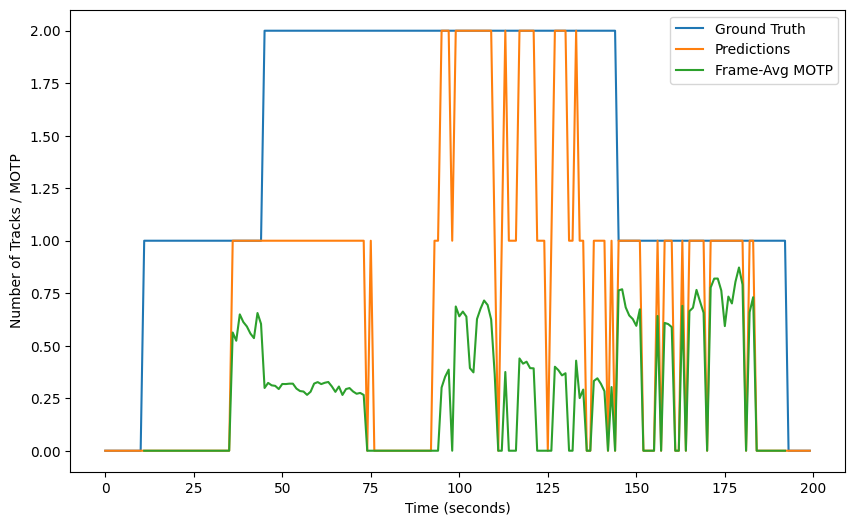

Evaluating easy1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

easy1.mp4 - MOTA: 0.78, MOTP: 0.63, IDF1: 0.69


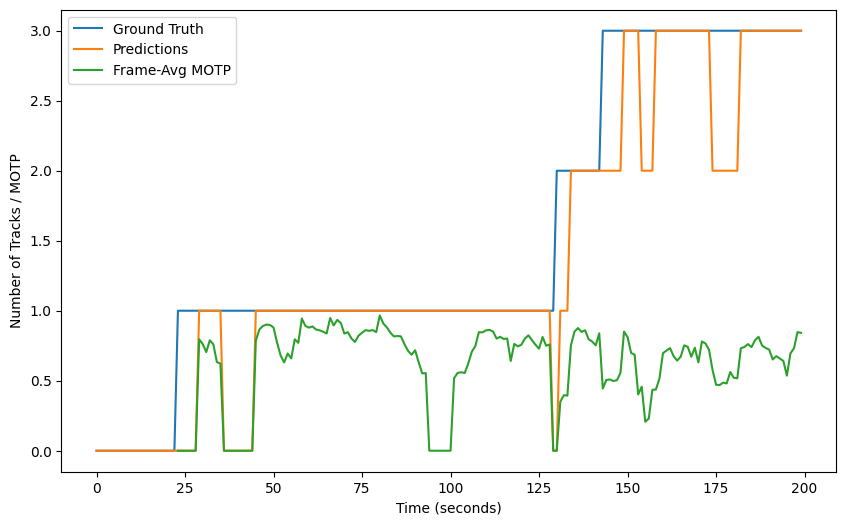

Evaluating difficult2.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

difficult2.mp4 - MOTA: 0.27, MOTP: 0.29, IDF1: 0.41


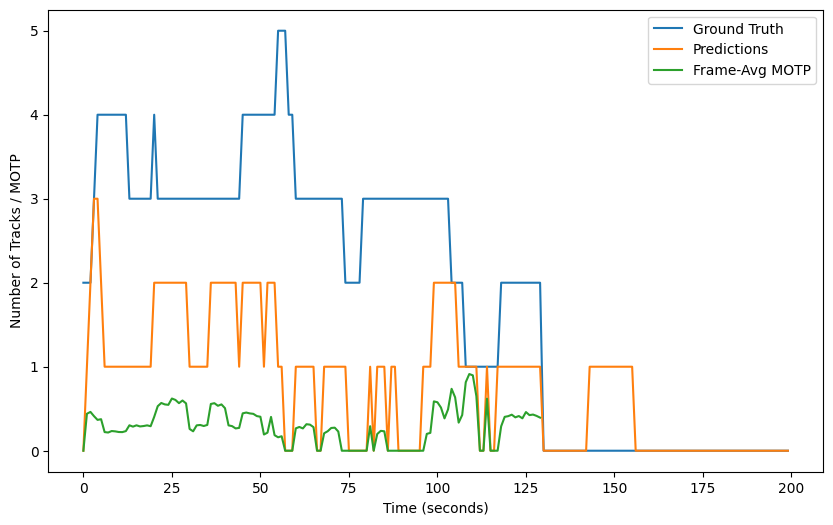

Evaluating difficult1.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

difficult1.mp4 - MOTA: 0.21, MOTP: 0.17, IDF1: 0.35


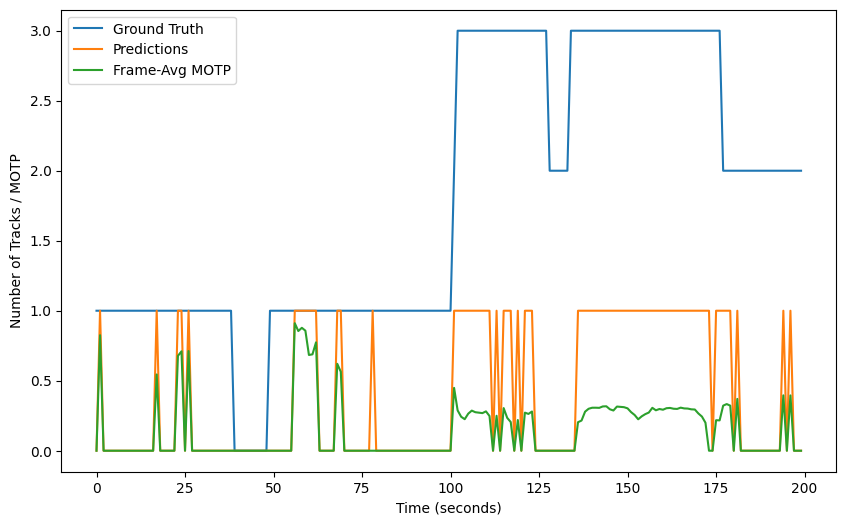

Evaluating easy2.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

easy2.mp4 - MOTA: 0.72, MOTP: 0.6, IDF1: 0.76


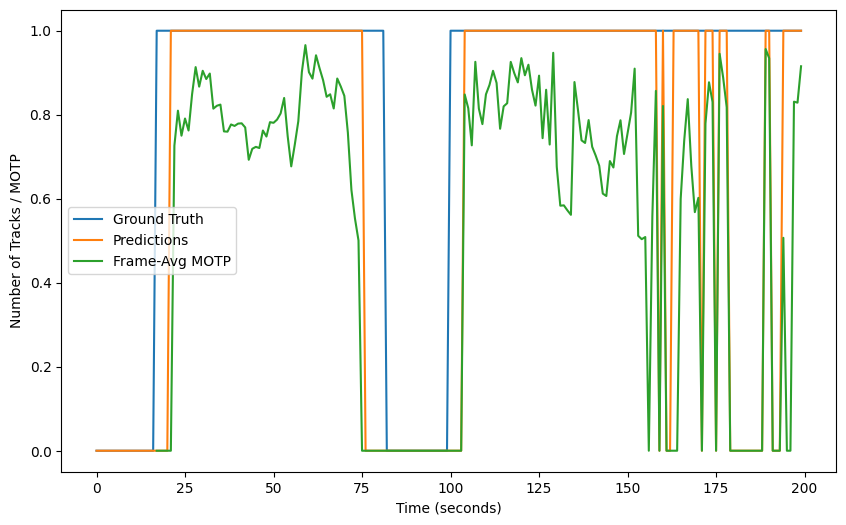

Evaluating medium2.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

medium2.mp4 - MOTA: 0.33, MOTP: 0.27, IDF1: 0.5


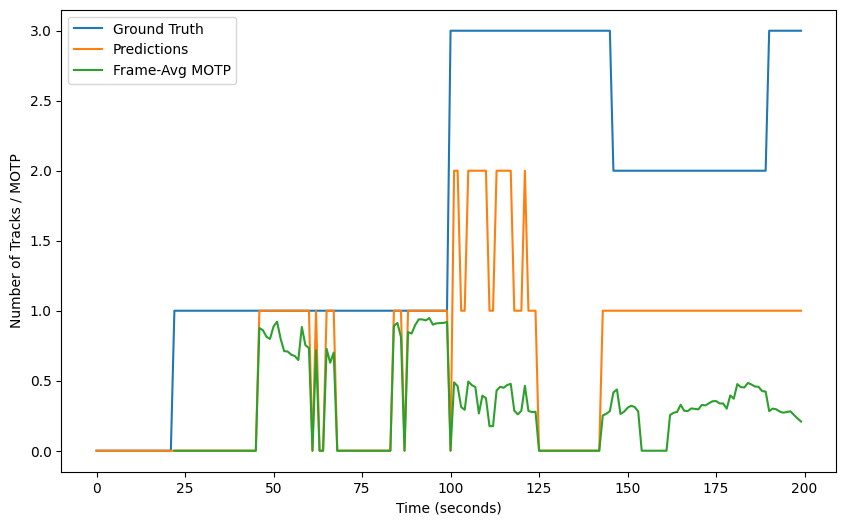

Avg results: MOTA: 0.43, MOTP: 0.37, IDF1: 0.52


In [ ]:
videos = os.listdir(video_folder)
print('testing model ' + model_path)
model = YOLO(model_path)

motas = []
motps = []
idf1s = []

for video in videos:
  print(f'Evaluating {video}')
  video_path = video_folder + video
  annotations_path = annotations_folder + video[:-4] + '.csv'
  annotations = pd.read_csv(annotations_path)
  results = model.track(source=video_path, persist=True, conf=CONF_TRESHOLD, verbose=False)
  extracted_pred_results = yolo_extract_tracks(results)
  aligned_annotations = align_annotations_with_predictions_dict_corrected(annotations, extracted_pred_results, VIDEO_LENGTH)
  mota, motp, idf1, frame_avg_motp = evaluate_tracking(aligned_annotations, IOU_ASSOCIATION_TRESHOLD)
  motas.append(mota)
  motps.append(motp)
  idf1s.append(idf1)
  print(f'{video} - MOTA: {round(mota, 2)}, MOTP: {round(motp, 2)}, IDF1: {round(idf1, 2)}')
  plot_performance_graph(aligned_annotations, frame_avg_motp)

print(f'Avg results: MOTA: {round(np.mean(motas), 2)}, MOTP: {round(np.mean(motps), 2)}, IDF1: {round(np.mean(idf1s), 2)}')